# Code for 3d large deformation viscoelasticity of elastomeric materials

- Simple tension of a 3D unit cube.
- Uses quadrature representation of internal variable: viscous deformation tensor Cv.


Eric Stewart 

ericstew@mit.edu  

Spring 2024

### Units
- Basic:
    - Length: mm
    - Mass: kg  
    - Time:  s
    - Mass density: kg/mm^3

- Derived:
    - Force: mN
    - Stress: kPa 
    - Energy: uJ

### Software:
- Dolfinx v0.8.0

# Import modules

In [2]:
# Import FEnicSx/dolfinx
import dolfinx

# For numerical arrays
import numpy as np

# For MPI-based parallelization
from mpi4py import MPI
comm = MPI.COMM_WORLD
rank = comm.Get_rank()

# PETSc solvers
from petsc4py import PETSc

# specific functions from dolfinx modules
from dolfinx import fem, mesh, io, plot, log
from dolfinx.fem import (Constant, dirichletbc, Function, functionspace, Expression )
from dolfinx.fem.petsc import NonlinearProblem
from dolfinx.nls.petsc import NewtonSolver
from dolfinx.io import VTXWriter, XDMFFile


# specific functions from ufl modules
import ufl
from ufl import (TestFunctions, TrialFunction, Identity, grad, det, div, dev, inv, tr, sqrt, conditional ,\
                 gt, dx, inner, derivative, dot, ln, split, exp, eq, cos, acos, ge, le)

# basix finite elements
import basix
from basix.ufl import element, mixed_element, quadrature_element

# Matplotlib for plotting
import matplotlib.pyplot as plt
plt.close('all')

# For timing the code
from datetime import datetime


# Set level of detail for log messages (integer)
# Guide:
# CRITICAL  = 50, // errors that may lead to data corruption
# ERROR     = 40, // things that HAVE gone wrong
# WARNING   = 30, // things that MAY go wrong later
# INFO      = 20, // information of general interest (includes solver info)
# PROGRESS  = 16, // what's happening (broadly)
# TRACE     = 13, // what's happening (in detail)
# DBG       = 10  // sundry
#
log.set_log_level(log.LogLevel.WARNING)

# Define geometry

In [3]:

# A 3-D cube
length = 1.0 # mm
domain = mesh.create_box(MPI.COMM_WORLD, [[0.0,0.0,0.0], [length,length,length]],\
                         [1,1,1], mesh.CellType.tetrahedron)

x = ufl.SpatialCoordinate(domain)

In [4]:
# Identify the planar boundaries of the  box mesh
#
def xBot(x):
    return np.isclose(x[0], 0)
def xTop(x):
    return np.isclose(x[0], length)
def yBot(x):
    return np.isclose(x[1], 0)
def yTop(x):
    return np.isclose(x[1], length)
def zBot(x):
    return np.isclose(x[2], 0)
def zTop(x):
    return np.isclose(x[2], length)
    
# Mark the sub-domains
boundaries = [(1, xBot),(2,xTop),(3,yBot),(4,yTop),(5,zBot),(6,zTop)]

# build collections of facets on each subdomain and mark them appropriately.
facet_indices, facet_markers = [], [] # initalize empty collections of indices and markers.
fdim = domain.topology.dim - 1 # geometric dimension of the facet (mesh dimension - 1)
for (marker, locator) in boundaries:
    facets = mesh.locate_entities(domain, fdim, locator) # an array of all the facets in a 
                                                         # given subdomain ("locator")
    facet_indices.append(facets)                         # add these facets to the collection.
    facet_markers.append(np.full_like(facets, marker))   # mark them with the appropriate index.

# Format the facet indices and markers as required for use in dolfinx.
facet_indices = np.hstack(facet_indices).astype(np.int32)
facet_markers = np.hstack(facet_markers).astype(np.int32)
sorted_facets = np.argsort(facet_indices)
# 
# Add these marked facets as "mesh tags" for later use in BCs.
facet_tags = mesh.meshtags(domain, fdim, facet_indices[sorted_facets], facet_markers[sorted_facets])

**Print out the unique facet index numbers**

In [5]:
top_imap = domain.topology.index_map(2)      # index map of 2D entities in domain (facets)
values = np.zeros(top_imap.size_global)      # an array of zeros of the same size as number of 2D entities
values[facet_tags.indices]=facet_tags.values # populating the array with facet tag index numbers
print(np.unique(facet_tags.values))          # printing the unique indices

[1 2 3 4 5 6]


**Visualize reference configuration and boundary facets**

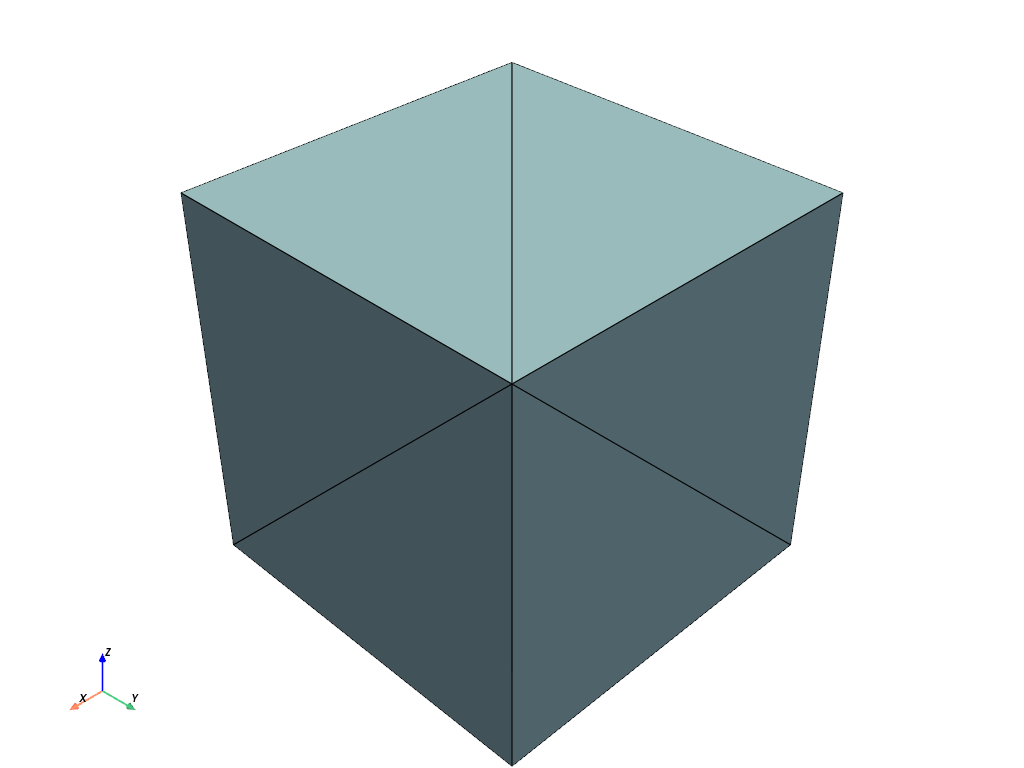

In [6]:
import pyvista
pyvista.set_jupyter_backend('html')
from dolfinx.plot import vtk_mesh
pyvista.start_xvfb()

# initialize a plotter
plotter = pyvista.Plotter()

# Add the mesh.
topology, cell_types, geometry = plot.vtk_mesh(domain, domain.topology.dim)
grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)
plotter.add_mesh(grid, show_edges=True) 

labels = dict(zlabel='Z', xlabel='X', ylabel='Y')
plotter.add_axes(**labels)
    
plotter.screenshot("results/cube_mesh.png")

from IPython.display import Image
Image(filename='results/cube_mesh.png') 

### Un-comment this cell to see an interactive visualization of the mesh

In [7]:
# plotter.show()

## Define boundary and volume integration measure

In [8]:
# Define the boundary integration measure "ds" using the facet tags,
# also specify the number of surface quadrature points.
ds = ufl.Measure('ds', domain=domain, subdomain_data=facet_tags, metadata={'quadrature_degree':4})

# Define the volume integration measure "dx" 
# also specify the number of volume quadrature points.
dx = ufl.Measure('dx', domain=domain, metadata={'quadrature_degree': 4})

#  Define facet normal
n = ufl.FacetNormal(domain)

# Material parameters

In [9]:
Geq_0   = Constant(domain, 15.36)      # Shear modulus, kPa
Kbulk = Constant(domain, PETSc.ScalarType(1.0e3*Geq_0))            # Bulk modulus, kPa
lambdaL = Constant(domain, 5.85)       # Arruda-Boyce locking stretch

# Viscoelasticity parameters from Wang et al (2016) for VHB4910
#
Gneq_1  = Constant(domain, 26.06)    #  Non-equilibrium shear modulus, kPa
tau_1   = Constant(domain, 0.6074)    #  relaxation time, s
#
Gneq_2  = Constant(domain, 26.53)    #  Non-equilibrium shear modulus, kPa
tau_2   = Constant(domain, 6.56)     #  relaxation time, s
# 
Gneq_3  = Constant(domain, 10.83)    #  Non-equilinrium shear modulus, kPa
tau_3   = Constant(domain, 61.25)    #  relaxation time, s

rho = Constant(domain, 1.0e-6) # Mass density, kg/mm^3

# alpha-method parameters
alpha   = Constant(domain, PETSc.ScalarType(0.0))
gamma   = Constant(domain, PETSc.ScalarType(0.5+alpha))
beta    = Constant(domain, PETSc.ScalarType(0.25*(gamma+0.5)**2))


# Simulation time-control related params

In [10]:
# Simulation time control-related params
t        = 0.0       # start time
Ttot     = 10       # total simulation time 
numSteps = 200       # integer number of steps
dt       = Ttot/numSteps   # (fixed) step size
dk       = Constant(domain, PETSc.ScalarType(dt))

# Compressive displacement paramters
stretch = 1.5
disp_tot = (stretch-1)*length    # final tip displacement (mm)
Tcutoff = 0.1   # time to stop ramp and hold displacement (s)

# Boundary condition to ramp up displacement
def dispRamp(t):
    if t<Tcutoff:
        disp = disp_tot*t/Tcutoff
    else:
        disp = disp_tot
    return disp

# Function spaces

In [11]:

U2 = element("Lagrange", domain.basix_cell(), 2, shape=(3,))  # For displacement
P1 = element("Lagrange", domain.basix_cell(), 1)  # For pressure
# P0 = element("Lagrange", domain.basix_cell(), 1)
# T0 = element("Lagrange", domain.basix_cell(), 1, shape=(3,3))
P0 = quadrature_element(domain.basix_cell(), degree=2, scheme="default") 
# Note: it seems that for the current version of dolfinx, 
# only degree=2 quadrature elements actually function properly 
# in e.g. visualization interpolations and problem solution.
T0 = basix.ufl.blocked_element(P0, shape=(3, 3)) # for Cv
#
TH = mixed_element([U2, P1])     # Taylor-Hood style mixed element
ME = functionspace(domain, TH)    # Total space for all DOFs
#
V1 = functionspace(domain, P0) # Scalar function space.
V2 = functionspace(domain, U2) # Vector function space
V3 = functionspace(domain, T0) # Tensor function space
#
# Define actual functions with the required DOFs
w        = Function(ME)
u, p = split(w)  

# A copy of functions to store values in the previous step
w_old             = Function(ME)
u_old,  p_old = split(w_old)   

# Define test functions        
u_test, p_test = TestFunctions(ME)    

# Define trial functions needed for automatic differentiation
dw = TrialFunction(ME)  

# Define a tensor-valued function for Cv.
Cv_1_old = Function(V3) 
Cv_2_old = Function(V3) 
Cv_3_old = Function(V3) 

# Functions for storing the velocity and acceleration at prev. step
v_old = Function(V2)
a_old = Function(V2)

# Initial conditions: 

# A function for constructing the identity matrix.
#
# To use the interpolate() feature, this must be defined as a 
# function of x.
def identity(x):
    values = np.zeros((domain.geometry.dim*domain.geometry.dim,
                      x.shape[1]), dtype=np.float64)
    values[0] = 1
    values[4] = 1
    values[8] = 1
    return values

# interpolate the identity onto the tensor-valued Cv function.
Cv_1_old.interpolate(identity)  
Cv_2_old.interpolate(identity) 
Cv_3_old.interpolate(identity)   

# Subroutines for kinematics and constitutive equations

In [12]:
#------------------------------------------------------------- 
# Utility subroutines
#-------------------------------------------------------------
 
# Subroutine for a "safer" sqrt() function which avoids a divide by zero 
# when differentiated. 
def safe_sqrt(x):
    return sqrt(x + 1.0e-16)

# Deformation gradient 
def F_calc(u):
    Id = Identity(3) 
    F = Id + grad(u) 
    return F

#------------------------------------------------------------- 
# Subroutines for computing the viscous flow update
#-------------------------------------------------------------

# Subroutine for computing the viscous stretch Cv at the end of the step.
def Cv_update(u, Cv_old, tau_r):
    
   F = F_calc(u)
   
   J = det(F)
   
   C = F.T*F
   
   fac = 1.0 + (1./3.) * ( dk / tau_r ) * J**(-2./3.) * inner(C, inv(Cv_old) )
   
   Cv_new = ( Cv_old + ( dk / tau_r ) * J**(-2./3.) * C )  / fac
   
   Cv_new_norm = Cv_new / det(Cv_new)**(1/3)
    
   return Cv_new_norm

#------------------------------------------------------------- 
# Subroutines for calculating the equilibrium Cauchy stress
#-------------------------------------------------------------

# Subrountine for computing the effective stretch
def lambdaBar_calc(u):
    
    F = F_calc(u)
    
    J = det(F)
    
    Fbar = J**(-1/3)*F
    
    Cbar = Fbar.T*Fbar
    
    I1 = tr(Cbar)
    
    lambdaBar = safe_sqrt(I1/3.0)
    
    return lambdaBar

# Subroutine for computing the zeta-function in the Arruda-Boyce model.
def zeta_calc(u):
    
    lambdaBar = lambdaBar_calc(u)
    
    # Use Pade approximation of Langevin inverse (A. Cohen, 1991)
    # This is sixth-order accurate.
    z    = lambdaBar/lambdaL
    
    z    = conditional(gt(z,0.99), 0.99, z) # Keep from blowing up
    
    beta = z*(3.0 - z**2.0)/(1.0 - z**2.0)
    
    zeta = (lambdaL/(3*lambdaBar))*beta
    
    return zeta

# Generalized shear modulus for Arruda-Boyce model
def Geq_AB_calc(u):
    
    zeta = zeta_calc(u)
    
    Geq_AB  = Geq_0 * zeta
    
    return Geq_AB

# Subroutine for calculating the  equilibrium Cauchy stress
def T_eq_calc(u,p):
    
    F   = F_calc(u)
    
    J = det(F)
    
    Fbar = J**(-1./3.)*F
    
    Bbar = Fbar*Fbar.T
    
    Geq  = Geq_AB_calc(u)
    
    T_eq = (1/J)* Geq * dev(Bbar) - p * Identity(3)
    
    return T_eq


#------------------------------------------------------------- 
# Subroutine for calculating the total Piola stress
#-------------------------------------------------------------
   
# Subroutine for the non-equilibrium Cauchy stress.
def T_neq_calc(u, Cv, Gneq):
        
    F  = F_calc(u)
    
    J = det(F)
    
    C = F.T*F
    
    T_neq = J**(-5./3.) * Gneq * (F * inv(Cv) * F.T - (1./3.) * inner(C, inv(Cv)) * Identity(3) ) 
    
    return T_neq
    
    
# Subroutine for the total Piola stress.
def  Piola_calc(u, p, Cv_1, Cv_2, Cv_3, Gneq_1, Gneq_2, Gneq_3):
    
    F  = F_calc(u)
    
    J = det(F)
    
    T_eq = T_eq_calc(u,p)
    
    T_neq_1 = T_neq_calc(u, Cv_1, Gneq_1)
    
    T_neq_2 = T_neq_calc(u, Cv_2, Gneq_2)
        
    T_neq_3 = T_neq_calc(u, Cv_3, Gneq_3)
    
    T = T_eq + T_neq_1 + T_neq_2 + T_neq_3
    
    Piola = J * T * inv(F.T)
    
    return Piola 

#---------------------------------------------------------------------
# Subroutine for updating  acceleration using the Newmark beta method:
# a = 1/(2*beta)*((u - u0 - v0*dt)/(0.5*dt*dt) - (1-2*beta)*a0)
#---------------------------------------------------------------------
def update_a(u, u_old, v_old, a_old):
    return (u-u_old-dk*v_old)/beta/dk**2 - (1-2*beta)/2/beta*a_old

#---------------------------------------------------------------------
# Subroutine for updating  velocity using the Newmark beta method
# v = dt * ((1-gamma)*a0 + gamma*a) + v0
#---------------------------------------------------------------------
def update_v(a, u_old, v_old, a_old):
    return v_old + dk*((1-gamma)*a_old + gamma*a)

#---------------------------------------------------------------------
# alpha-method averaging function
#---------------------------------------------------------------------
def avg(x_old, x_new, alpha):
    return alpha*x_old + (1-alpha)*x_new

# Evaluate kinematics and constitutive relations

In [13]:
# Get acceleration and velocity at end of step
a_new = update_a(u, u_old, v_old, a_old)
v_new = update_v(a_new, u_old, v_old, a_old)

# get avg (u,p) fields for generalized-alpha method
u_avg  = avg(u_old, u, alpha)
p_avg  = avg(p_old, p, alpha)

# Kinematical quantities
F  = F_calc(u_avg)
J  = det(F)
lambdaBar = lambdaBar_calc(u_avg)

# update the Cv tensors
Cv_1 = Cv_update(u_avg, Cv_1_old, tau_1)
Cv_2 = Cv_update(u_avg, Cv_2_old, tau_2)
Cv_3 = Cv_update(u_avg, Cv_3_old, tau_3)

#  Evaulate the total Piola stress
Piola = Piola_calc(u_avg, p_avg, Cv_1, Cv_2, Cv_3, Gneq_1, Gneq_2, Gneq_3)

# Weak forms

In [14]:
# The weak form for the equilibrium equation
#
Res_1  =  inner( Piola, grad(u_test))*dx \
          #+ inner(rho * a_new, u_test)*dx 
          # (we exclude inertial effects for now)
              
# The auxiliary equation for the pressure
#
Res_2 = inner((J-1) + p_avg/Kbulk, p_test)*dx

# The weak form for the viscous strain increment updates

# The total residual
Res = Res_1 + Res_2 

# Automatic differentiation tangent:
a = derivative(Res, w, dw)

# Set-up output files

In [15]:
# results file name
results_name = "3D_stress_relaxation"

# Function space for projection of results
P1 = element("Lagrange", domain.basix_cell(), 1)
VV1 = fem.functionspace(domain, P1) # linear scalar function space
#
U1 = element("Lagrange", domain.basix_cell(), 1, shape=(3,)) 
VV2 = fem.functionspace(domain, U1) # linear Vector function space
#
T1 = element("Lagrange", domain.basix_cell(), 1, shape=(3,3)) 
VV3 = fem.functionspace(domain, T1) # linear tensor function space

# For visualization purposes, we need to re-project the stress tensor onto a linear function space before 
# we write it (and its components and the von Mises stress, etc) to the VTX file. 
#
# This is because the stress is a complicated "mixed" function of the (quadratic Lagrangian) displacements
# and the (quadrature representation) plastic strain tensor and scalar equivalent plastic strain. 
#
# First, define a function for setting up this kind of projection problem for visualization purposes:
def setup_projection(u, V):

    trial = ufl.TrialFunction(V)
    test  = ufl.TestFunction(V)   

    a = ufl.inner(trial, test)*dx
    L = ufl.inner(u, test)*dx

    projection_problem = dolfinx.fem.petsc.LinearProblem(a, L, [], \
        petsc_options={"ksp_type": "cg", "ksp_rtol": 1e-16, "ksp_atol": 1e-16, "ksp_max_it": 1000})
    
    return projection_problem

# Create a linear problem for projecting the stress tensor onto the linear tensor function space VV3.
#
tensor_projection_problem = setup_projection(Piola, VV3)
Piola_temp = tensor_projection_problem.solve()

In [16]:
# primary fields to write to output file
u_vis      = Function(VV2, name="disp")
p_vis      = Function(VV1, name="p")

In [17]:

# Mises stress
T     = Piola_temp*F.T/J
T0    = T - (1/3)*tr(T)*Identity(3)
Mises = sqrt((3/2)*inner(T0, T0))
Mises_vis= Function(VV1,name="Mises")
Mises_expr = Expression(Mises,VV1.element.interpolation_points())

# Cauchy stress components
T11 = Function(VV1)
T11.name = "T11"
T11_expr = Expression(T[0,0],VV1.element.interpolation_points())

T22 = Function(VV1)
T22.name = "T22"
T22_expr = Expression(T[1,1],VV1.element.interpolation_points())

T33 = Function(VV1)
T33.name = "T33"
T33_expr = Expression(T[2,2],VV1.element.interpolation_points())


In [18]:
# Effective stretch
lambdaBar_vis      = Function(VV1)
lambdaBar_vis.name = "LambdaBar"
lambdaBar_expr     = Expression(lambdaBar, VV1.element.interpolation_points())

# Volumetric deformation
J_vis      = Function(VV1)
J_vis.name = "J"
J_expr     = Expression(J, VV1.element.interpolation_points())

In [19]:
# set up the output VTX files.
file_results = VTXWriter(
    MPI.COMM_WORLD,
    "results/" + results_name + ".bp",
    [  # put the functions here you wish to write to output
        u_vis, p_vis, # DOF outputs
        Mises_vis, T11, T22, T33, # stress outputs
        lambdaBar_vis, J_vis, # Kinematical outputs
    ],
    engine="BP4",
)

def writeResults(t):
    
    # Update the output fields before writing to VTX.
    #
    u_vis.interpolate(w.sub(0))
    p_vis.interpolate(w.sub(1))
    #
    # re-project to smooth visualization of quadrature functions
    # before interpolating.
    Piola_temp = tensor_projection_problem.solve()
    Mises_vis.interpolate(Mises_expr)
    T11.interpolate(T11_expr)
    T22.interpolate(T22_expr)
    T33.interpolate(T33_expr)
    #
    lambdaBar_vis.interpolate(lambdaBar_expr)
    J_vis.interpolate(J_expr)
       
    # Finally, write output fields to VTX.
    #
    file_results.write(t) 

# Infrastructure for pulling out time history data (force, displacement, etc.)

In [20]:
# computing the reaction force using the stress field
traction = dot(Piola_temp, n)
Force    = dot(traction, n)*ds(4)
rxnForce = fem.form(Force) 

In [21]:
# # infrastructure for evaluating functions at a certain point efficiently
# pointForEval = np.array([length, length, length])
# bb_tree = dolfinx.geometry.bb_tree(domain,domain.topology.dim)
# cell_candidates = dolfinx.geometry.compute_collisions_points(bb_tree, pointForEval)
# colliding_cells = dolfinx.geometry.compute_colliding_cells(domain, cell_candidates, pointForEval).array

## Boundary condtions

In [22]:
# Constant for applied displacement
disp_cons = Constant(domain,PETSc.ScalarType(dispRamp(0)))

# Find the specific DOFs which will be constrained.
xBot_u1_dofs = fem.locate_dofs_topological(ME.sub(0).sub(0), facet_tags.dim, facet_tags.find(1))
yBot_u2_dofs = fem.locate_dofs_topological(ME.sub(0).sub(1), facet_tags.dim, facet_tags.find(3))
zBot_u3_dofs = fem.locate_dofs_topological(ME.sub(0).sub(2), facet_tags.dim, facet_tags.find(5))
yTop_u2_dofs = fem.locate_dofs_topological(ME.sub(0).sub(1), facet_tags.dim, facet_tags.find(4))

# building Dirichlet BCs
bcs_1 = dirichletbc(0.0, xBot_u1_dofs, ME.sub(0).sub(0))  # u1 fix - xBot
bcs_2 = dirichletbc(0.0, yBot_u2_dofs, ME.sub(0).sub(1))  # u2 fix - yBot
bcs_3 = dirichletbc(0.0, zBot_u3_dofs, ME.sub(0).sub(2))  # u3 fix - zBot
#
bcs_4 = dirichletbc(disp_cons, yTop_u2_dofs, ME.sub(0).sub(1))  # disp ramp - yTop

bcs = [bcs_1, bcs_2, bcs_3, bcs_4]

## Define the nonlinear variational problem

In [23]:
# Set up nonlinear problem
problem = NonlinearProblem(Res, w, bcs, a)

# the global newton solver and params
solver = NewtonSolver(MPI.COMM_WORLD, problem)
solver.convergence_criterion = "incremental"
solver.rtol = 1e-8
solver.atol = 1e-8
solver.max_it = 50
solver.report = True

#  The Krylov solver parameters.
ksp = solver.krylov_solver
opts = PETSc.Options()
option_prefix = ksp.getOptionsPrefix()
opts[f"{option_prefix}ksp_type"] = "preonly" # "preonly" works equally well
opts[f"{option_prefix}pc_type"] = "lu" # do not use 'gamg' pre-conditioner
opts[f"{option_prefix}pc_factor_mat_solver_type"] = "mumps"
opts[f"{option_prefix}ksp_max_it"] = 30
ksp.setFromOptions()


##  Start calculation loop

In [24]:
# Give the step a descriptive name
step = "Tension"

# Variables for storing time history
totSteps = 1000000
timeHist0 = np.zeros(shape=[totSteps])
timeHist1 = np.zeros(shape=[totSteps]) 
timeHist2 = np.zeros(shape=[totSteps]) 

#Iinitialize a counter for reporting data
ii=0

#  Set up temporary "helper" functions and expressions 
#  for updating the internal variables.
#
# For the Cv tensors:
Cv_1_temp = Function(V3)
Cv_1_expr = Expression(Cv_1, V3.element.interpolation_points())
#
Cv_2_temp = Function(V3)
Cv_2_expr = Expression(Cv_2, V3.element.interpolation_points())
#
Cv_3_temp = Function(V3)
Cv_3_expr = Expression(Cv_3, V3.element.interpolation_points())
#
# and also for the velocity and acceleration.
v_temp = Function(V2)
a_temp = Function(V2)
#
v_expr = Expression(v_new,V2.element.interpolation_points())
a_expr = Expression(a_new,V2.element.interpolation_points())

# Write initial state to file
writeResults(t=0.0)    

# print a message for simulation startup
print("------------------------------------")
print("Simulation Start")
print("------------------------------------")
# Store start time 
startTime = datetime.now()

# Time-stepping solution procedure loop
while (round(t + dt, 9) <= Ttot):
     
    # increment time
    t += dt 
    
    # increment counter
    ii += 1
    
    # update time variables in time-dependent BCs 
    disp_cons.value = dispRamp(t)
    
    # Solve the problem
    (iter, converged) = solver.solve(w)
    
    # Collect results from MPI ghost processes
    w.x.scatter_forward()

    # Print progress of calculation periodically
    if ii%5 == 0:      
      now = datetime.now()
      current_time = now.strftime("%H:%M:%S")
      print("Step: {} |   Increment: {} | Iterations: {}".format(step, ii, iter))
      print("dt: {} s | Simulation Time: {} s  of  {} s".format(round(dt, 4), round(t,4), Ttot))
      print()   
      
    # Write output to file
    writeResults(t)
       
    # Store time history variables at this time  
    timeHist0[ii] = t # current time 
    #
    timeHist1[ii] = dispRamp(t) # time history of displacement
    #
    timeHist2[ii] = domain.comm.gather(fem.assemble_scalar(rxnForce))[0] # time history of engineering stress
    
    # update internal variables 
    #
    # interpolate the values of the internal variables into their "temp" functions
    Cv_1_temp.interpolate(Cv_1_expr)
    Cv_2_temp.interpolate(Cv_2_expr)
    Cv_3_temp.interpolate(Cv_3_expr)
    #
    v_temp.interpolate(v_expr)
    a_temp.interpolate(a_expr)

    # Update DOFs for next step
    w_old.x.array[:] = w.x.array
    
    # update the old values of internal variables for next step
    Cv_1_old.x.array[:] = Cv_1_temp.x.array[:]
    Cv_2_old.x.array[:] = Cv_2_temp.x.array[:]
    Cv_3_old.x.array[:] = Cv_3_temp.x.array[:]
    #
    v_old.x.array[:] = v_temp.x.array[:]
    a_old.x.array[:] = a_temp.x.array[:]
    
# close the output file.
file_results.close()
         
# End analysis
print("-----------------------------------------")
print("End computation")                 
# Report elapsed real time for the analysis
endTime = datetime.now()
elapseTime = endTime - startTime
print("------------------------------------------")
print("Elapsed real time:  {}".format(elapseTime))
print("------------------------------------------")


------------------------------------
Simulation Start
------------------------------------
Step: Tension |   Increment: 5 | Iterations: 3
dt: 0.05 s | Simulation Time: 0.25 s  of  10 s

Step: Tension |   Increment: 10 | Iterations: 3
dt: 0.05 s | Simulation Time: 0.5 s  of  10 s

Step: Tension |   Increment: 15 | Iterations: 3
dt: 0.05 s | Simulation Time: 0.75 s  of  10 s

Step: Tension |   Increment: 20 | Iterations: 3
dt: 0.05 s | Simulation Time: 1.0 s  of  10 s

Step: Tension |   Increment: 25 | Iterations: 3
dt: 0.05 s | Simulation Time: 1.25 s  of  10 s

Step: Tension |   Increment: 30 | Iterations: 3
dt: 0.05 s | Simulation Time: 1.5 s  of  10 s

Step: Tension |   Increment: 35 | Iterations: 3
dt: 0.05 s | Simulation Time: 1.75 s  of  10 s

Step: Tension |   Increment: 40 | Iterations: 3
dt: 0.05 s | Simulation Time: 2.0 s  of  10 s

Step: Tension |   Increment: 45 | Iterations: 3
dt: 0.05 s | Simulation Time: 2.25 s  of  10 s

Step: Tension |   Increment: 50 | Iterations: 3
dt

# Plot results

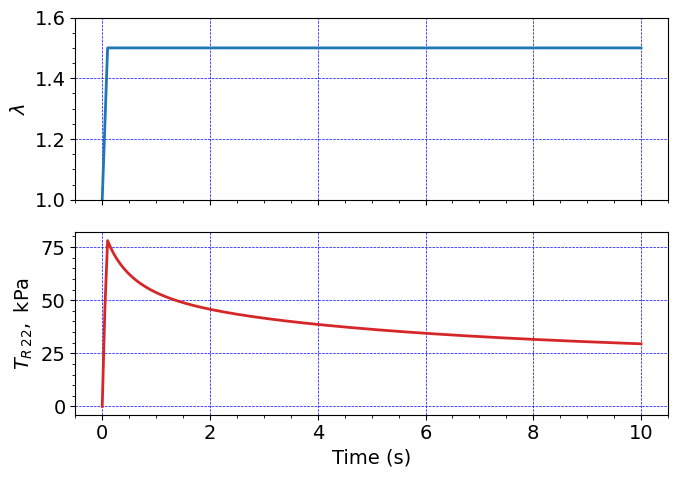

In [25]:
# Set plot font to size 14
font = {'size'   : 14}
plt.rc('font', **font)

# Get array of default plot colors
prop_cycle = plt.rcParams['axes.prop_cycle']
colors     = prop_cycle.by_key()['color']

# Only plot as far as we have time history data
ind = np.argmax(timeHist0) +1


# multi-plot figure
fig, (ax1, ax2) = plt.subplots(2,1, sharex='col')

ax2.plot(timeHist0[0:ind], timeHist2[0:ind]/(length*length), c=colors[3], linewidth=2.0)
ax2.grid(linestyle="--", linewidth=0.5, color='b')
ax2.set_ylabel(r'$T_{R \, 22},$ kPa')
ax2.set_xlabel('Time (s)')
from matplotlib.ticker import AutoMinorLocator,FormatStrFormatter
ax2.xaxis.set_minor_locator(AutoMinorLocator())
ax2.yaxis.set_minor_locator(AutoMinorLocator())

ax1.plot(timeHist0[0:ind], timeHist1[0:ind]/length + 1, c=colors[0], linewidth=2.0)
ax1.grid(linestyle="--", linewidth=0.5, color='b')
ax1.set_ylabel(r'$\lambda$')
from matplotlib.ticker import AutoMinorLocator,FormatStrFormatter
ax1.xaxis.set_minor_locator(AutoMinorLocator())
ax1.yaxis.set_minor_locator(AutoMinorLocator())
ax1.set_ylim(1.0,1.6)
#plt.show()

fig = plt.gcf()
fig.set_size_inches(7,5)
plt.tight_layout()
plt.savefig("results/finite_viscoelastic_stress_relaxation.png", dpi=600)
